In [89]:
import numpy as np
from numpy import where
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
sns.set_style("darkgrid")

## General Dataset

In [2]:
general = pd.read_csv('General_Payments_2020.csv', parse_dates=['Date_of_Payment', 'Payment_Publication_Date'], 
                     dtype={'Teaching_Hospital_CCN': np.float32,
                            'Teaching_Hospital_ID': np.float16, 
                            'Physician_Profile_ID' : np.float32, 
                            'Total_Amount_of_Payment_USDollars': np.float32, 
                            'Number_of_Payments_in_Total_Amount': np.int16, 
                            'Record_ID': np.int32})

/Users/marcusyeo/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (4,7,9,11,14,16,17,21,22,23,24,27,34,35,36,39,40,41,42,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
general_raw = general.copy()
general.head()

,Change_Type,Covered_Recipient_Type,Teaching_Hospital_CCN,Teaching_Hospital_ID,Teaching_Hospital_Name,Physician_Profile_ID,Physician_First_Name,Physician_Middle_Name,Physician_Last_Name,Physician_Name_Suffix,...,Type_Ind_4,Product_Category_or_Therapeutic_Area_4,Product_Name_4,Associated_Drug_or_Biological_NDC_4,Covered_or_Noncovered_Ind_5,Type_Ind_5,Product_Category_or_Therapeutic_Area_5,Product_Name_5,Associated_Drug_or_Biological_NDC_5,Payment_Publication_Date
0,UNCHANGED,Covered Recipient Physician,NaN,NaN,NaN,557946.0,Vikas,Kumar,Pilly,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-21
1,UNCHANGED,Covered Recipient Physician,NaN,NaN,NaN,276936.0,Matthew,NaN,Hall,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-21
2,UNCHANGED,Covered Recipient Physician,NaN,NaN,NaN,1275463.0,Stephen,NaN,Campbell,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-21
3,UNCHANGED,Covered Recipient Physician,NaN,NaN,NaN,268352.0,Leroy,Pearce,McCarty,III,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-21
4,UNCHANGED,Covered Recipient Physician,NaN,NaN,NaN,904225.0,Michael,John,Latza,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-21


### Using Pearson Correlation to get a sensing of different features

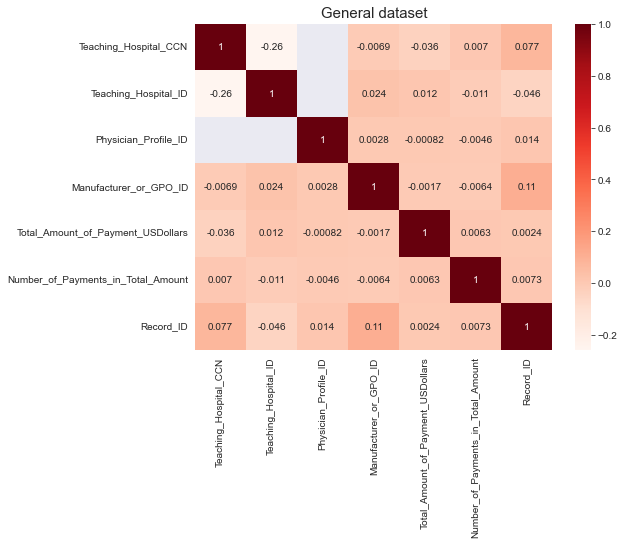

In [6]:
#Using Pearson Correlation
plt.figure(figsize=(8,6))
plt.title('General dataset',fontsize=15)
cor = general_raw.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

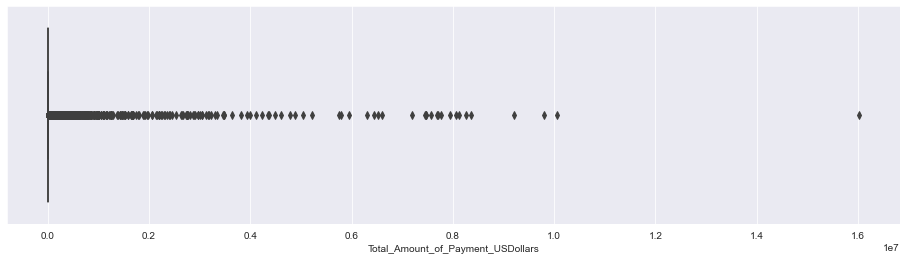

In [7]:
plt.figure(figsize=(16,4))
sns.boxplot(data=general_raw,x ='Total_Amount_of_Payment_USDollars')
plt.show()

### Anomaly Detection with Isolation Forests for Single Feature

/Users/marcusyeo/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


 1    5766769
-1        433
Name: anomaly, dtype: int64


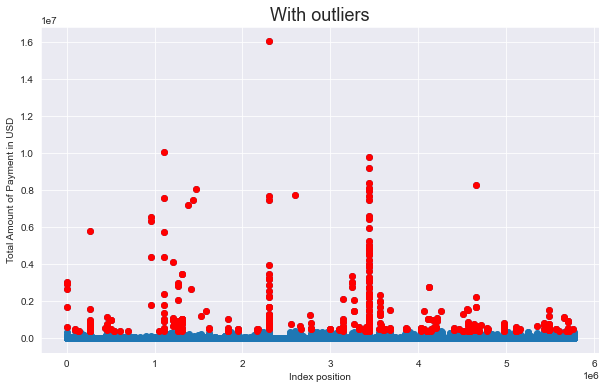

In [8]:
model = IsolationForest(contamination= 0.0001, random_state = 101)
model.fit(general[['Total_Amount_of_Payment_USDollars']])

general['index'] = general.index
general['scores'] = model.decision_function(general[['Total_Amount_of_Payment_USDollars']])
general['anomaly'] = model.predict(general[['Total_Amount_of_Payment_USDollars']])

print(general['anomaly'].value_counts())

outlier_index = where(general['anomaly'] == -1) 
outlier_values = general.iloc[outlier_index]

plt.figure(figsize=(10,6))
plt.scatter(general['index'],general['Total_Amount_of_Payment_USDollars'])
plt.scatter(outlier_values['index'], outlier_values['Total_Amount_of_Payment_USDollars'], c = "r")
plt.title('With outliers',fontsize=18)
plt.ylabel('Total Amount of Payment in USD')
plt.xlabel('Index position')
plt.show()

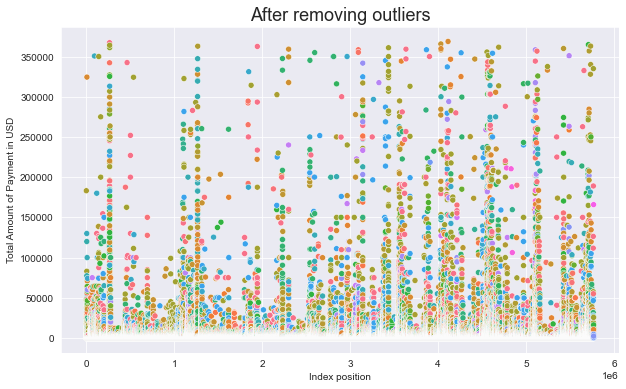

In [9]:
list_index = list(outlier_index[0])
general.drop(list_index, axis=0, inplace=True)

plt.figure(figsize=(10,6))
# plt.scatter(general['index'],general['Total_Amount_of_Payment_USDollars'])
sns.scatterplot(data=general,x='index',y='Total_Amount_of_Payment_USDollars',hue='Recipient_State',legend=False)
plt.title('After removing outliers',fontsize=18)
plt.ylabel('Total Amount of Payment in USD')
plt.xlabel('Index position')
plt.show()

### Analysing Outliers for Total Payment in General Payment

In [10]:
# outlier_values.columns

In [11]:
# outlier_values.describe()

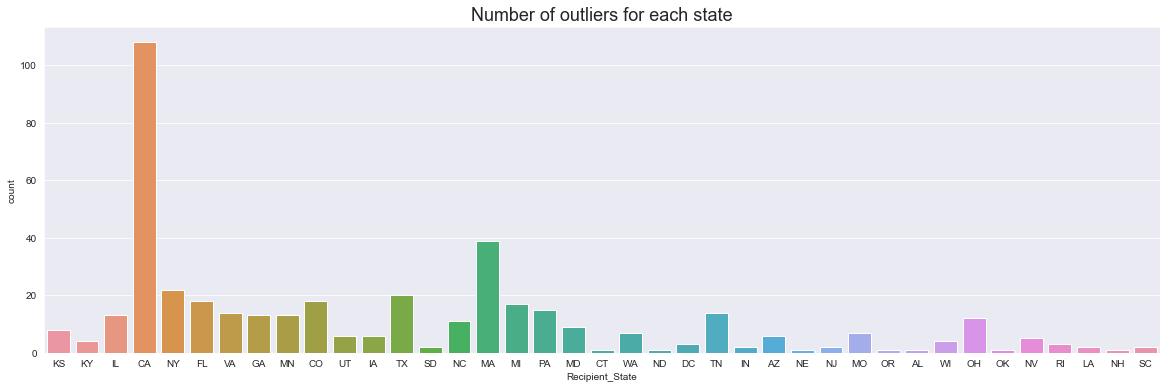

In [12]:
plt.figure(figsize=(20,6))
sns.countplot(data=outlier_values,x='Recipient_State')
plt.title('Number of outliers for each state',fontsize=18)
plt.show()

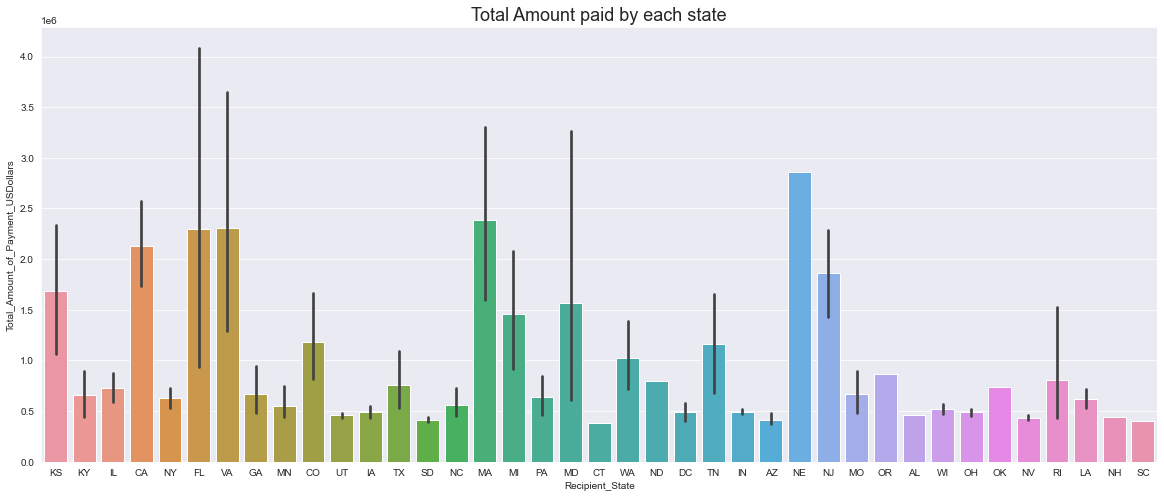

In [13]:
plt.figure(figsize=(20,8))
sns.barplot(data=outlier_values,x='Recipient_State',y='Total_Amount_of_Payment_USDollars',estimator=np.mean)
plt.title('Total Amount paid by each state',fontsize=18)
plt.show()

### Picking out disparities

In [14]:
NE = outlier_values[outlier_values['Recipient_State'] == 'NE']
NE

,Change_Type,Covered_Recipient_Type,Teaching_Hospital_CCN,Teaching_Hospital_ID,Teaching_Hospital_Name,Physician_Profile_ID,Physician_First_Name,Physician_Middle_Name,Physician_Last_Name,Physician_Name_Suffix,...,Associated_Drug_or_Biological_NDC_4,Covered_or_Noncovered_Ind_5,Type_Ind_5,Product_Category_or_Therapeutic_Area_5,Product_Name_5,Associated_Drug_or_Biological_NDC_5,Payment_Publication_Date,index,scores,anomaly
2299887,UNCHANGED,Covered Recipient Physician,NaN,NaN,NaN,1008618.0,HEBER,C.,CROCKETT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-21,2299887,-0.001771,-1


In [15]:
# for x in NE.iloc[0]:
#     print(x)

> Conclusion: NE's single payment related to the acquisition of Avenu Medical.

In [16]:
FL = outlier_values[outlier_values['Recipient_State'] == 'FL']

In [17]:
FL.head()

,Change_Type,Covered_Recipient_Type,Teaching_Hospital_CCN,Teaching_Hospital_ID,Teaching_Hospital_Name,Physician_Profile_ID,Physician_First_Name,Physician_Middle_Name,Physician_Last_Name,Physician_Name_Suffix,...,Associated_Drug_or_Biological_NDC_4,Covered_or_Noncovered_Ind_5,Type_Ind_5,Product_Category_or_Therapeutic_Area_5,Product_Name_5,Associated_Drug_or_Biological_NDC_5,Payment_Publication_Date,index,scores,anomaly
263886,UNCHANGED,Covered Recipient Physician,NaN,NaN,NaN,258909.0,ANDREW,JEREMY,COOPER,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-21,263886,-0.001771,-1
1311817,UNCHANGED,Covered Recipient Physician,NaN,NaN,NaN,5705128.0,BRIAN,MICHAEL,SNELLING,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-21,1311817,-0.001771,-1
1311818,UNCHANGED,Covered Recipient Physician,NaN,NaN,NaN,217494.0,ERIC,C.,PETERSON,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-21,1311818,-0.001771,-1
1312185,UNCHANGED,Covered Recipient Teaching Hospital,100079.0,9472.0,University Of Miami Hosp & Clinics,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-21,1312185,-0.001180,-1
1943614,UNCHANGED,Covered Recipient Physician,NaN,NaN,NaN,231549.0,THOMAS,W,WRIGHT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-21,1943614,-0.001180,-1


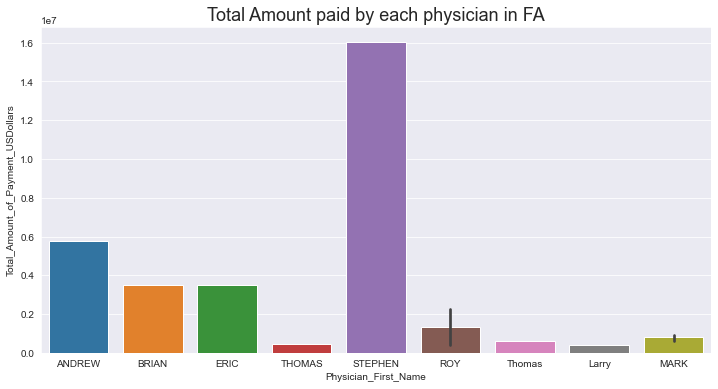

In [18]:
plt.figure(figsize=(12,6))
sns.barplot(data=FL,x='Physician_First_Name',y='Total_Amount_of_Payment_USDollars',estimator=np.mean)
plt.title('Total Amount paid by each physician in FA',fontsize=18)
plt.show()

In [19]:
# for x in general_raw.iloc[2299889]:
#     print(x)

> Conclusion: Stephen's payment related to the acquisition of Avenu Medical.

In [20]:
acq = general_raw[general_raw['Contextual_Information'] == 'Payment related to the acquisition of Avenu Medical.']

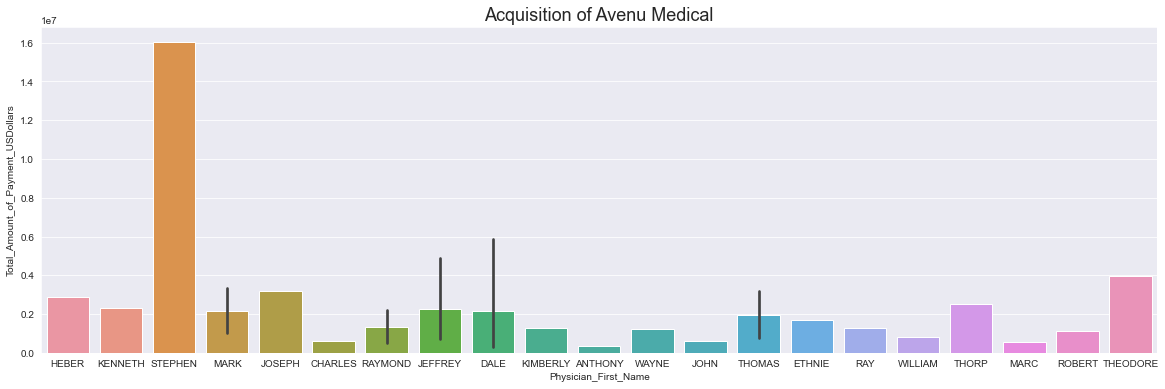

In [21]:
plt.figure(figsize=(20,6))
sns.barplot(data=acq,x='Physician_First_Name',y='Total_Amount_of_Payment_USDollars',estimator=np.mean)
plt.title('Acquisition of Avenu Medical',fontsize=18)
plt.show()

In [22]:
# for i in general_raw.iloc[2299889]:
#     print(i)

> Conclusion: Because Stephen is the chairman of Avenu Medical

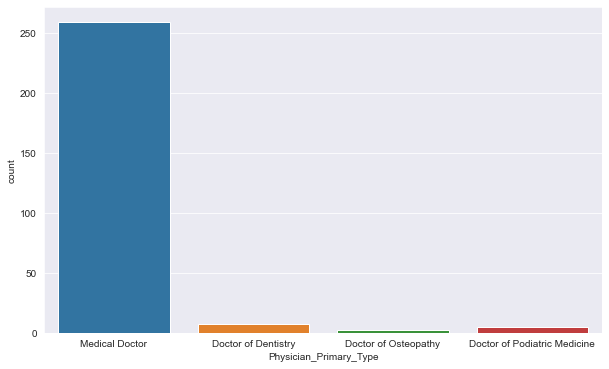

In [23]:
plt.figure(figsize=(10,6))
sns.countplot(data=outlier_values,x='Physician_Primary_Type')
plt.show()

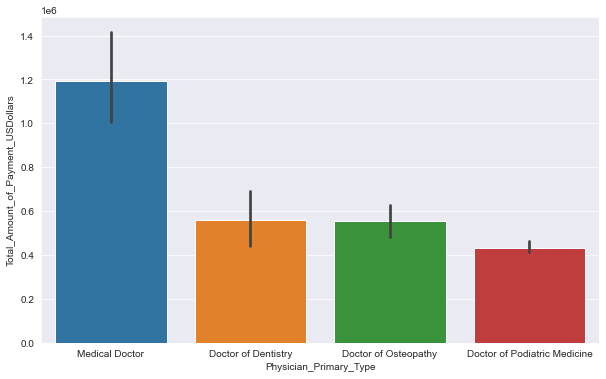

In [24]:
plt.figure(figsize=(10,6))
sns.barplot(data=outlier_values,x='Physician_Primary_Type',y='Total_Amount_of_Payment_USDollars',estimator=np.mean)
plt.show()

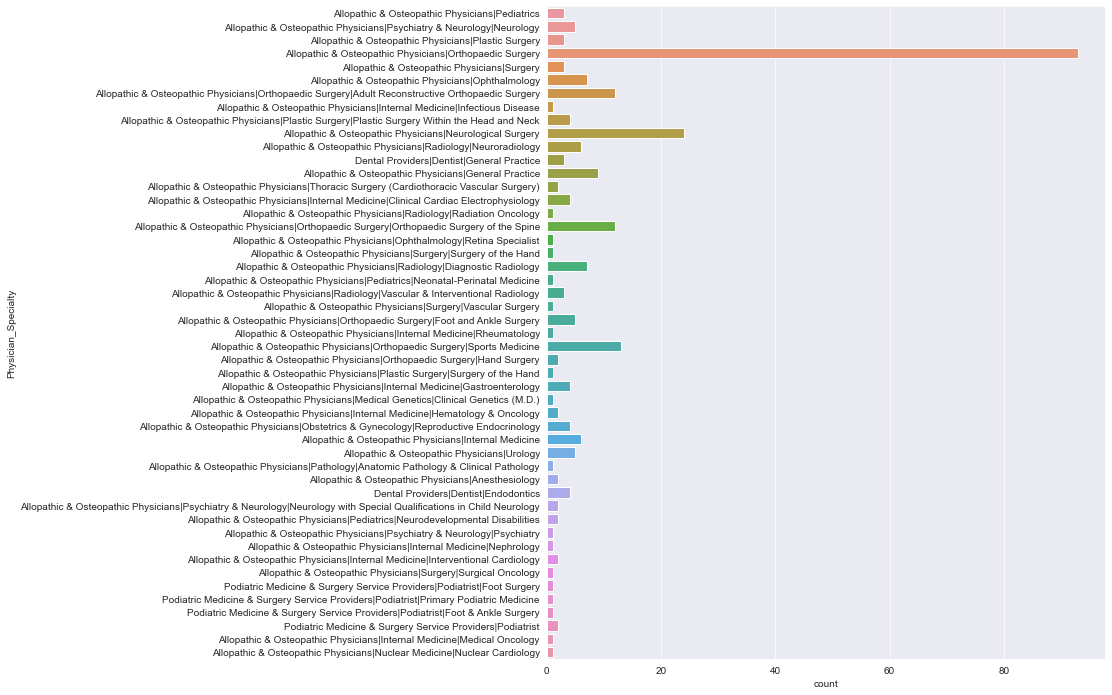

In [25]:
plt.figure(figsize=(10,12))
sns.countplot(data=outlier_values,y='Physician_Specialty')
plt.show()

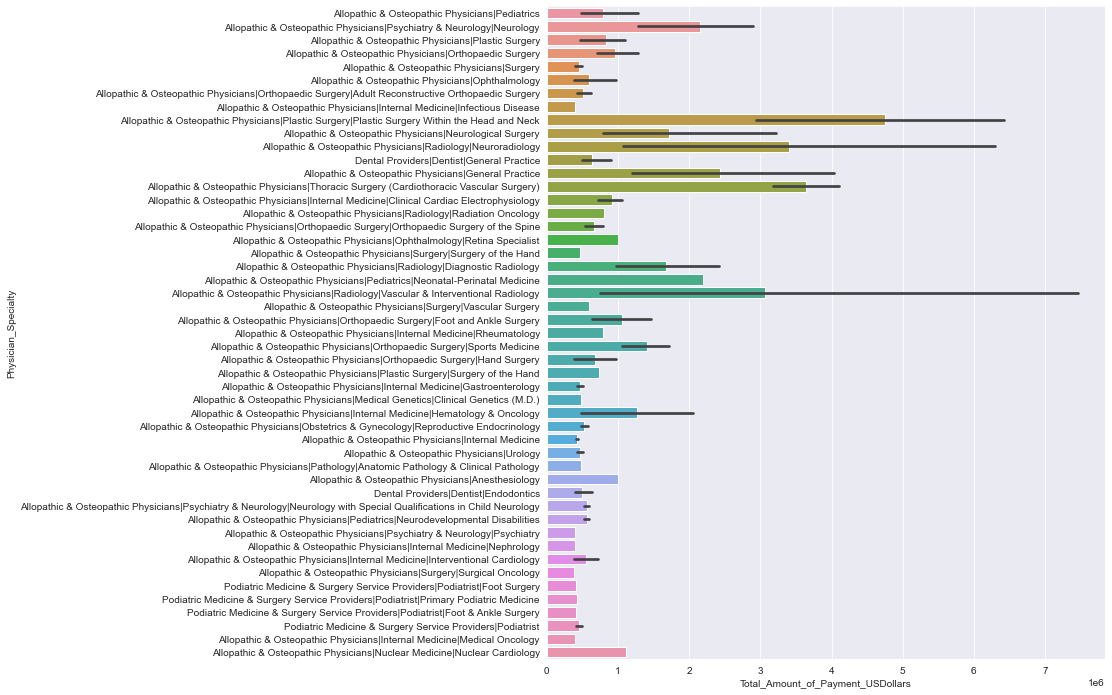

In [26]:
plt.figure(figsize=(10,12))
sns.barplot(data=outlier_values,y='Physician_Specialty',x='Total_Amount_of_Payment_USDollars',estimator=np.mean)
plt.show()

## Investments Dataset

In [32]:
investments = pd.read_csv('Ownership_Investment_2020.csv')

In [33]:
investments_raw = investments.copy()
investments.head()

,Change_Type,Physician_Profile_ID,Physician_First_Name,Physician_Middle_Name,Physician_Last_Name,Physician_Name_Suffix,Recipient_Primary_Address_Line_1,Recipient_Primary_Address_Line_2,Recipient_City,Recipient_State,...,Record_ID,Total_Amount_Invested_USDollars,Value_of_Interest,Terms_of_Interest,Manufacturer_or_GPO_ID,Manufacturer_or_GPO_Name,Manufacturer_or_GPO_State,Manufacturer_or_GPO_Country,Interest_Held_by_Physician_or_Family,Payment_Publication_Date
0,UNCHANGED,134335,Aysha,NaN,Khalid,NaN,1225 Kennedy Blvd,NaN,Bayonne,NJ,...,729093639,0.0,5000.0,Common Stock,100000216802,Cornerstone Specialty Network LLC,PA,United States,Physician Covered Recipient,01/21/2022
1,UNCHANGED,997719,Jamie,NaN,Koprivnikar,NaN,39 High Street,NaN,Montclair,NJ,...,729093643,0.0,9000.0,Common Stock,100000216802,Cornerstone Specialty Network LLC,PA,United States,Physician Covered Recipient,01/21/2022
2,UNCHANGED,32057,Peter,NaN,Kourlas,NaN,810 Jasonway Ave,Suite A,Columbus,OH,...,729093645,0.0,9000.0,Common Stock,100000216802,Cornerstone Specialty Network LLC,PA,United States,Physician Covered Recipient,01/21/2022
3,UNCHANGED,887574,Gurpreet,NaN,Lamba,NaN,1 Milton Ct,NaN,Marlboro Township,NJ,...,729093649,0.0,9000.0,Common Stock,100000216802,Cornerstone Specialty Network LLC,PA,United States,Physician Covered Recipient,01/21/2022
4,UNCHANGED,138170,Craig,NaN,Lampert,NaN,75 Veronica Ave,Suite 201,Somerset,NJ,...,729093653,0.0,9000.0,Common Stock,100000216802,Cornerstone Specialty Network LLC,PA,United States,Physician Covered Recipient,01/21/2022


### Using Pearson Correlation to get a sensing of different features

In [34]:
investments_dropped = investments.drop('Recipient_Province',axis=1)
investments_dropped = investments_dropped.drop('Recipient_Postal_Code',axis=1)

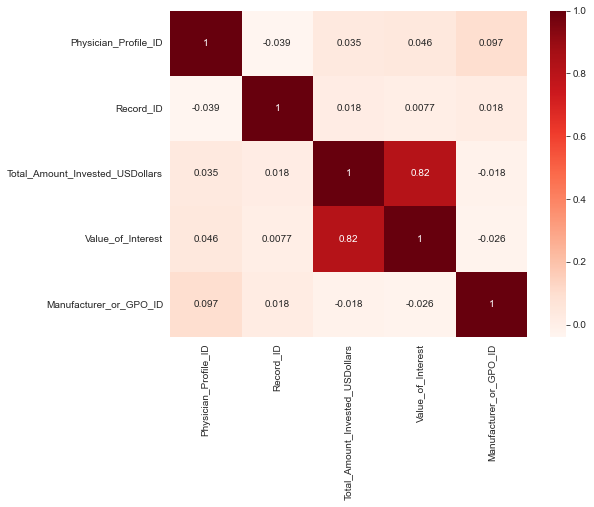

In [35]:
plt.figure(figsize=(8,6))
cor = investments_dropped.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

/Users/marcusyeo/anaconda3/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


 1    3205
-1      33
Name: anomaly, dtype: int64


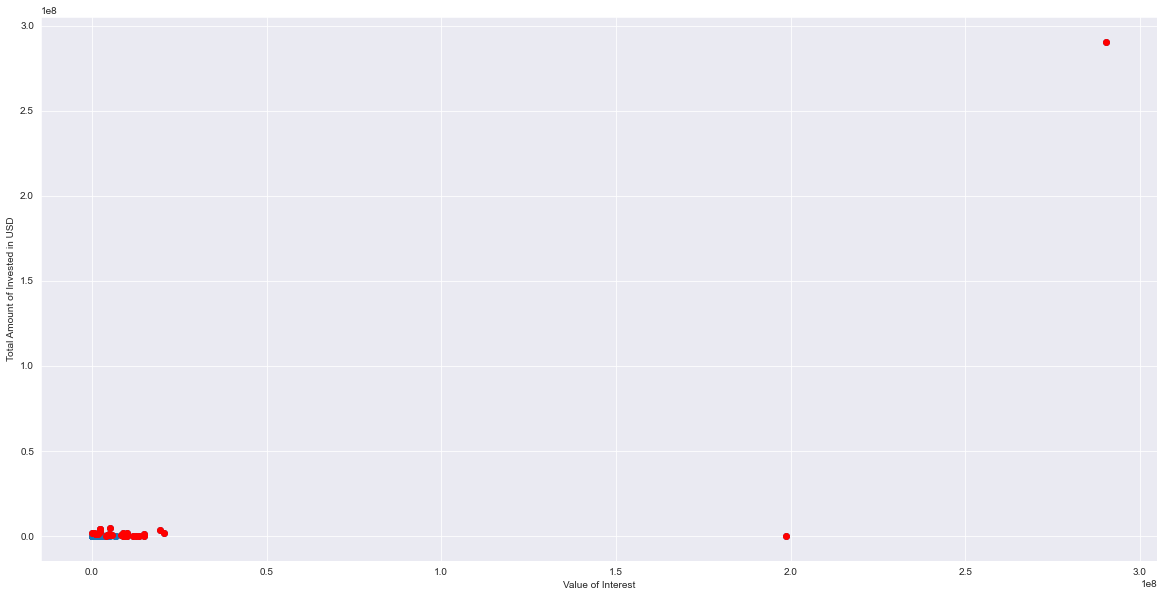

In [36]:
model2 = IsolationForest(contamination= 0.01, random_state = 101)
model2.fit(investments[['Value_of_Interest','Total_Amount_Invested_USDollars']])

investments['index'] = investments.index
investments['scores'] = model2.decision_function(investments[['Value_of_Interest','Total_Amount_Invested_USDollars']])
investments['anomaly'] = model2.predict(investments[['Value_of_Interest','Total_Amount_Invested_USDollars']])

print(investments['anomaly'].value_counts())
outlier_index2 = where(investments['anomaly'] == -1) 
outlier_values2 = investments.iloc[outlier_index2]

plt.figure(figsize=(20,10))
plt.scatter(investments['Value_of_Interest'],investments['Total_Amount_Invested_USDollars'])
plt.scatter(outlier_values2['Value_of_Interest'], outlier_values2['Total_Amount_Invested_USDollars'], c = "r")
plt.ylabel('Total Amount of Invested in USD')
plt.xlabel('Value of Interest')
plt.show()

In [37]:
outlier_index2

(array([ 261,  283,  349,  367,  376,  458,  459,  471,  738,  890, 1383,
        1387, 1625, 1878, 1879, 2001, 2002, 2003, 2005, 2171, 2224, 2291,
        2349, 2350, 2363, 2443, 2452, 2498, 2590, 2595, 2817, 2925, 2926]),)

In [38]:
investments.drop([ 261,  283,  349,  367,  376,  458,  459,  471,  738,  890, 1383,
                   1387, 1625, 1878, 1879, 2001, 2002, 2003, 2005, 2171, 2224, 2291,
                   2349, 2350, 2363, 2443, 2452, 2498, 2590, 2595, 2817, 2925, 2926], axis=0, inplace=True)

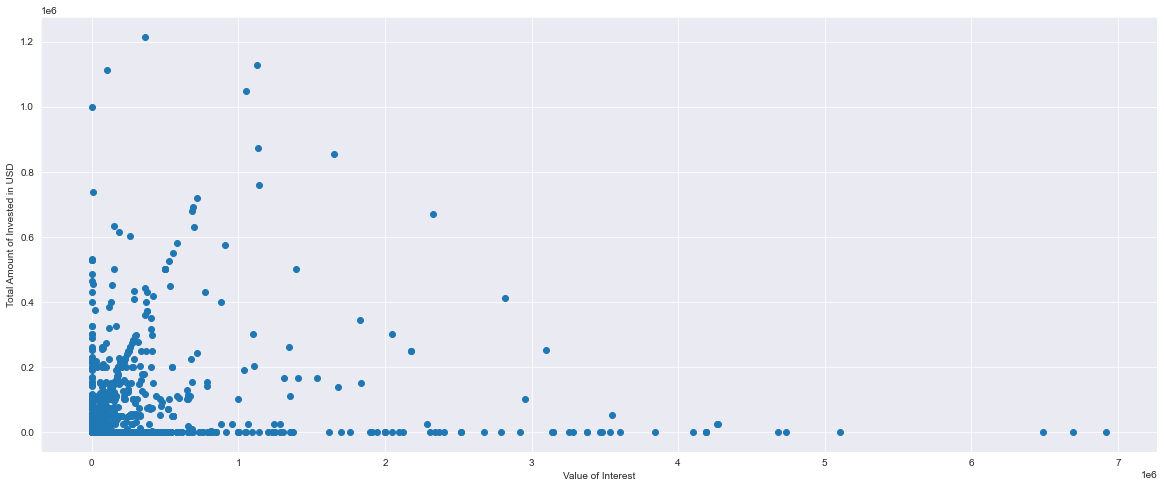

In [39]:
plt.figure(figsize=(20,8))
plt.scatter(investments['Value_of_Interest'],investments['Total_Amount_Invested_USDollars'])
plt.ylabel('Total Amount of Invested in USD')
plt.xlabel('Value of Interest')
plt.show()

In [40]:
investments['natural_log_voi'] = np.log(investments['Value_of_Interest'])
investments['natural_log_total'] = np.log(investments['Total_Amount_Invested_USDollars'])

/Users/marcusyeo/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


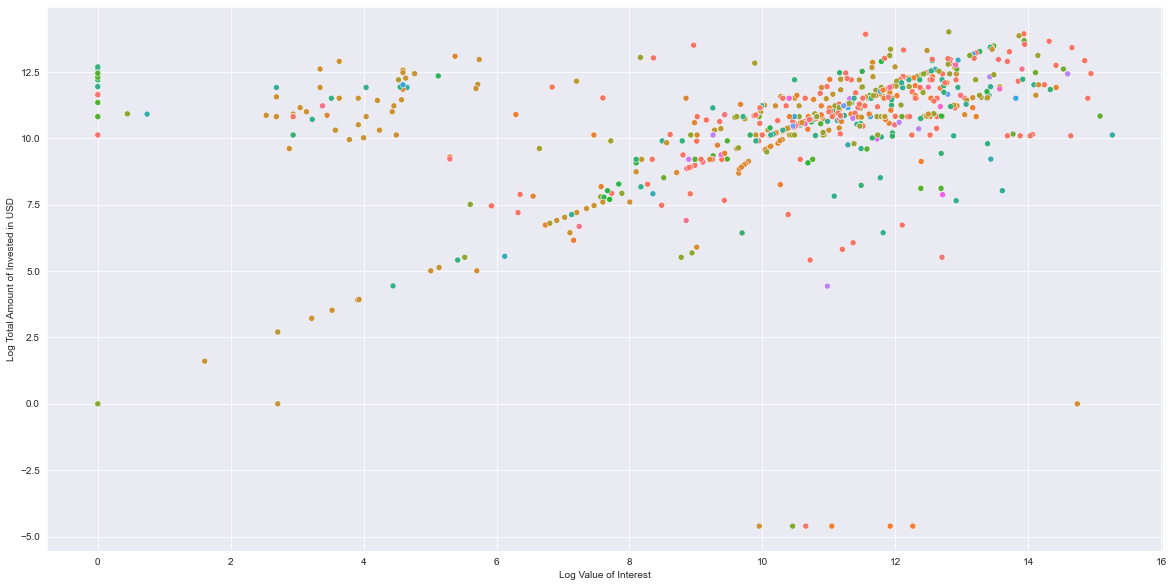

In [41]:
plt.figure(figsize=(20,10))
sns.scatterplot(data = investments,
                x = 'natural_log_voi',
                y = 'natural_log_total',
                hue = 'Physician_Specialty')
plt.ylabel('Log Total Amount of Invested in USD')
plt.xlabel('Log Value of Interest')
plt.legend([],[], frameon=False)
plt.show()

## Research Dataset

In [42]:
research = pd.read_csv('Research_Payments_2020.csv')

/Users/marcusyeo/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (2,5,7,8,9,10,17,18,19,20,21,22,23,24,32,33,38,39,43,44,45,46,51,52,53,59,60,61,95,100,101,102) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [44]:
research_raw = research.copy()
research.head()

,Change_Type,Covered_Recipient_Type,Noncovered_Recipient_Entity,Teaching_Hospital_CCN,Teaching_Hospital_ID,Teaching_Hospital_Name,Physician_Profile_ID,Physician_First_Name,Physician_Middle_Name,Physician_Last_Name,...,Expenditure_Category5,Expenditure_Category6,Preclinical_Research_Ind,Delay_in_Publication_Ind,Name_of_Study,Record_ID,Payment_Publication_Date,ClinicalTrials_Gov_Identifier,Research_Information_Link,Context_of_Research
0,UNCHANGED,Covered Recipient Teaching Hospital,NaN,220110.0,8641.0,Brigham And Womens Hospital,NaN,NaN,NaN,NaN,...,NaN,NaN,No,No,PE Study (PE) / Optalyse,734742797,01/21/2022,NCT02396758,NaN,NaN
1,UNCHANGED,Covered Recipient Teaching Hospital,NaN,310001.0,8837.0,HACKENSACK UNIVERSITY MEDICAL CENTER,NaN,NaN,NaN,NaN,...,NaN,NaN,No,No,"A Phase III, Randomized, Double-blind, Matchin...",740785267,01/21/2022,NaN,NaN,Equipment or non-drug supplies provided to a c...
2,UNCHANGED,Covered Recipient Physician,NaN,NaN,NaN,NaN,166707.0,Bernard,NaN,Ashby,...,NaN,NaN,No,No,DIAMOND PAT-CR-302,750382175,01/21/2022,NaN,NaN,NaN
3,UNCHANGED,Covered Recipient Teaching Hospital,NaN,50047.0,9847.0,CALIFORNIA PACIFIC MEDICAL CENTER,NaN,NaN,NaN,NaN,...,NaN,NaN,No,No,"A STUDY OF SAPANISERTIB, COMBINATION OF SAPANI...",737060227,01/21/2022,NaN,NaN,NaN
4,UNCHANGED,Covered Recipient Teaching Hospital,NaN,100258.0,9699.0,Delray Medical Center,NaN,NaN,NaN,NaN,...,NaN,NaN,No,No,KNOCOUT PE,734743057,01/21/2022,NCT03426124,NaN,NaN


### Using Pearson Correlation to get a sensing of different features

In [45]:
to_drop = ['Physician_Profile_ID',
           'Physician_License_State_code5',
           'Pr_Investigator_2_License_State_code4',
           'Pr_Investigator_2_License_State_code5',
           'Pr_Investigator_3_License_State_code3',
           'Pr_Investigator_3_License_State_code4',
           'Pr_Investigator_3_License_State_code5',
           'Pr_Investigator_4_License_State_code2',
           'Pr_Investigator_4_License_State_code3',
           'Pr_Investigator_4_License_State_code4',
           'Pr_Investigator_4_License_State_code5',
           'Pr_Investigator_5_License_State_code2',
           'Pr_Investigator_5_License_State_code3',
           'Pr_Investigator_5_License_State_code4',
           'Pr_Investigator_5_License_State_code5',
           'Expenditure_Category5',
           'Expenditure_Category6']

research.drop(columns=to_drop,inplace=True)

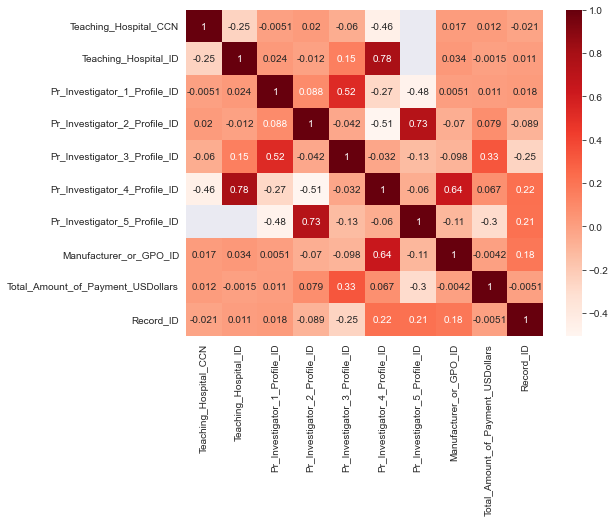

In [46]:
plt.figure(figsize=(8,6))
cor = research.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

## Trends of Payment for Chronic Conditions

In [83]:
chronic_2016 = pd.read_csv('Specific_Chronic_Conditions_2016_data.csv')
chronic_2017 = pd.read_csv('Specific_Chronic_Conditions_2017_data.csv')
chronic_2018 = pd.read_csv('Specific_Chronic_Conditions_2018_data.csv')

In [84]:
chronic_2018.head()

,Bene_Geo_Lvl,Bene_Geo_Desc,Bene_Geo_Cd,Bene_Age_Lvl,Bene_Demo_Lvl,Bene_Demo_Desc,Bene_Cond,Prvlnc,Tot_Mdcr_Stdzd_Pymt_PC,Tot_Mdcr_Pymt_PC,Hosp_Readmsn_Rate,ER_Visits_Per_1000_Benes
0,State,Alabama,1.0,All,All,All,Alcohol Abuse,0.0188,25102.3405,23348.6039,0.2413,2184.7557
1,State,Alabama,1.0,65+,Dual Status,Medicare Only,Alcohol Abuse,0.0118,NaN,NaN,NaN,NaN
2,State,Alabama,1.0,<65,Dual Status,Medicare Only,Alcohol Abuse,0.0320,NaN,NaN,NaN,NaN
3,State,Alabama,1.0,All,Dual Status,Medicare Only,Alcohol Abuse,0.0147,NaN,NaN,NaN,NaN
4,State,Alabama,1.0,65+,Dual Status,Medicare and Medicaid,Alcohol Abuse,0.0238,NaN,NaN,NaN,NaN


In [85]:
chronic_2018_dropped = chronic_2018.dropna(subset=['Tot_Mdcr_Stdzd_Pymt_PC'])
chronic_2017_dropped = chronic_2017.dropna(subset=['Tot_Mdcr_Stdzd_Pymt_PC'])
chronic_2016_dropped = chronic_2016.dropna(subset=['Tot_Mdcr_Stdzd_Pymt_PC'])

In [169]:
# chronic_2018_dropped.drop(['Bene_Geo_Lvl','Bene_Geo_Cd','Bene_Age_Lvl','Bene_Demo_Desc'],axis=1)

## Finding Correlation for Cancer Mortality Rate

In [167]:
us_states = pd.read_csv('us_states.csv')
cancer_rate = pd.read_csv('cancer_mortality_rate_2020.csv')
quality_of_life = pd.read_csv('quality_of_life_2022.csv')
health = pd.read_csv('healthiest_states.csv')
poverty = pd.read_csv('poverty_rate_2022.csv')

In [170]:
# df_new = pd.merge(quality_of_life,us_states,how='inner')
# df_new2 = pd.merge(df_new,cancer_rate,how='inner',left_on='Code',right_on='STATE') 
# df_new2['DEATHS'] = df_new2['DEATHS'].replace(',','', regex=True)
# df_new2['DEATHS'] = pd.to_numeric(df_new2['DEATHS'])
# quality_cleaned = df_new2.drop(['URL','Abbrev','STATE'],axis=1)
# df_new3 = pd.merge(df_new2,health,how='inner')
# overall = df_new3.drop('URL',axis=1)
# temp = df_new3[['RATE','DEATHS','smokingRate','obesityRate','physicalInactivityRate','excessiveDrinkingRate']]

In [171]:
# overall = pd.merge(overall,poverty,how='inner')
# poverty_corr = overall[['PovertyRate','RATE']]
# temp2 = overall[['RATE','DEATHS','smokingRate','obesityRate','physicalInactivityRate','excessiveDrinkingRate','PovertyRate']]
# temp2 = temp2.rename(columns={'Cancer Mortality Rate':'Cancer Mortality Rate'})
# temp2 = temp2.rename(columns={'DEATHS':'Deaths'})

In [136]:
quality_cleaned[quality_cleaned['State'] == 'California']

,State,lifeQualityRank,healthCareRank,educationRank,economyRank,Code,YEAR,RATE,DEATHS
144,California,19,7,21,4,CA,2020,130.3,59778
145,California,19,7,21,4,CA,2019,131.6,59512
146,California,19,7,21,4,CA,2018,135.0,59962
147,California,19,7,21,4,CA,2017,136.7,59516
148,California,19,7,21,4,CA,2016,139.7,59515
149,California,19,7,21,4,CA,2015,142.8,59629
150,California,19,7,21,4,CA,2014,144.1,58412
151,California,19,7,21,4,CA,2005,168.9,54732


In [166]:
plt.figure(figsize=(12,8),dpi=900)
cor = temp2.corr(method='kendall')
sns.heatmap(cor, annot=True, cmap='YlGnBu')
plt.show()

In [126]:
plt.figure(figsize=(12,8),dpi=1000)
cor = df_new2.corr(method='kendall')
sns.heatmap(cor, annot=True, cmap='YlGnBu')
plt.show()

In [110]:
print(stats.pointbiserialr(temp['RATE'],temp['smokingRate']))

PointbiserialrResult(correlation=0.639695799630229, pvalue=2.0383923288141044e-47)


In [91]:
print(stats.pointbiserialr(df_new2['lifeQualityRank'],df_new2['RATE']))
print(stats.pointbiserialr(df_new2['healthCareRank'],df_new2['RATE']))
print(stats.pointbiserialr(df_new2['educationRank'],df_new2['RATE']))
print(stats.pointbiserialr(df_new2['economyRank'],df_new2['RATE']))

PointbiserialrResult(correlation=0.41259531899056223, pvalue=7.130808382730809e-18)
PointbiserialrResult(correlation=0.49474614839590525, pvalue=4.379186003973505e-26)
PointbiserialrResult(correlation=0.3440029302296842, pvalue=1.487782922918653e-12)
PointbiserialrResult(correlation=0.33509935237466526, pvalue=5.945010056520036e-12)


In [143]:
print(stats.pointbiserialr(df_new2['lifeQualityRank'],df_new2['DEATHS']))
print(stats.pointbiserialr(df_new2['healthCareRank'],df_new2['DEATHS']))
print(stats.pointbiserialr(df_new2['educationRank'],df_new2['DEATHS']))
print(stats.pointbiserialr(df_new2['economyRank'],df_new2['DEATHS']))

PointbiserialrResult(correlation=0.014283616694846488, pvalue=0.7758028495035518)
PointbiserialrResult(correlation=-0.07236823154705797, pvalue=0.14853375017714981)
PointbiserialrResult(correlation=-0.1029600483781721, pvalue=0.03956810769141468)
PointbiserialrResult(correlation=-0.21468729873493397, pvalue=1.4849382102741284e-05)
